In [1]:
from chainer.datasets import mnist

train, test = mnist.get_mnist(withlabel=True, ndim=1)

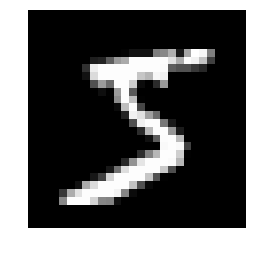

label 5


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label', t)

In [3]:
from chainer import iterators

batchsize = 128

train_iter  = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [4]:
import random
import numpy
random.seed(0)
numpy.random.seed(0)

import chainer
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(0)

In [5]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        
       # パラメータを持つ層の登録
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = -1  # CPUを用いる場合は、この値を-1にしてください

net = MLP()

if gpu_id >= 0:
    net.to_gpu(gpu_id)

In [6]:
print("1つ目の全結合層のバイアスパラメーターの形は", net.l1.b.shape)
print("初期化直後のその値は", net.l1.b.data)

1つ目の全結合層のバイアスパラメーターの形は (100,)
初期化直後のその値は [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [7]:
from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(net)

In [12]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 100

while train_iter.epoch < max_epoch:
    
    # 学習1のイテレーション
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, gpu_id)
    
    # 予測値の計算
    y = net(x)
    
    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)
    
    # 勾配の計算
    net.cleargrads()
    loss.backward()
    
    # パラメーターの更新
    optimizer.update()
    
    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎用性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:
        
        # ロスの表示
        print("epoch:{:02d} train_loss:{:.04f}".format(train_iter.epoch, float(to_cpu(loss.data))), end="")
        
        test_losses = []
        test_accuracies = []
        
        while True:
            test_batch = test_iter.next()
            x_test, t_test = concat_examples(test_batch, gpu_id)
            
            # テストデータをforward
            y_test = net(x_test)
            
            # ロスを計算
            loss_test = F.softmax_cross_entropy(y_test, t_test)
            test_losses.append(to_cpu(loss_test.data))
            
            # 精度を計算
            accuracy = F.accuracy(y_test, t_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)
            
            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break
                
        print("val_loss:{:.04f} val_accuracy:{:.04f}".format(np.mean(test_losses), np.mean(test_accuracies)))

epoch:11 train_loss:0.2130val_loss:0.2416 val_accuracy:0.9290
epoch:12 train_loss:0.2695val_loss:0.2361 val_accuracy:0.9310
epoch:13 train_loss:0.2522val_loss:0.2294 val_accuracy:0.9324
epoch:14 train_loss:0.1509val_loss:0.2217 val_accuracy:0.9356
epoch:15 train_loss:0.2564val_loss:0.2156 val_accuracy:0.9370
epoch:16 train_loss:0.1653val_loss:0.2090 val_accuracy:0.9381
epoch:17 train_loss:0.2528val_loss:0.2037 val_accuracy:0.9400
epoch:18 train_loss:0.1533val_loss:0.1993 val_accuracy:0.9410
epoch:19 train_loss:0.1843val_loss:0.1929 val_accuracy:0.9432
epoch:20 train_loss:0.1524val_loss:0.1879 val_accuracy:0.9433
epoch:21 train_loss:0.1156val_loss:0.1839 val_accuracy:0.9443
epoch:22 train_loss:0.2510val_loss:0.1782 val_accuracy:0.9464
epoch:23 train_loss:0.1269val_loss:0.1741 val_accuracy:0.9487
epoch:24 train_loss:0.3170val_loss:0.1701 val_accuracy:0.9480
epoch:25 train_loss:0.1771val_loss:0.1662 val_accuracy:0.9506
epoch:26 train_loss:0.1504val_loss:0.1619 val_accuracy:0.9513
epoch:27

In [13]:
from chainer import serializers

serializers.save_npz("my_mnist.model", net)

# ちゃんと保存されていることを確認
% ls -la my_mnist.model

-rw-r--r--  1 kazuki  staff  333940 12 10 16:13 my_mnist.model


In [14]:
# まず同じネットワークのオブジェクトを作る
infer_net = MLP()

# そのオブジェクトに保存済みパラメーターをロードする
serializers.load_npz("my_mnist.model", infer_net)

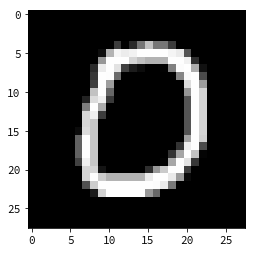

元の形: (784,)->ミニバッチの形にしたあと: (1, 784)
ネットワークの予測: 0


In [17]:
gpu_id = -1

if gpu_id >= 0:
    infer_net.to_gpu(gpu_id)
    
# 1つ目のテストデータを取り出します
x, t = test[10] # tは使わない

# どんな画像かを表示します
plt.imshow(x.reshape(28, 28), cmap="gray")
plt.show()

# ミニバッチの形にする(複数の画像をまとめて推論に使いたい場合は、サイズnのミニバッチにしてまとめれば良い)
print("元の形:", x.shape, end="->")

x = x[None, ...]

print("ミニバッチの形にしたあと:", x.shape)

# ネットワークと同じデバイス上にデータを送る
x = infer_net.xp.asarray(x)

# モデルのforward関数に渡す
y = infer_net(x)

# Variable形式で出てくるので中身を取り出す
y = y.array

# 結果をCPUに送る
y = to_cpu(y)

# 予測確率の最大値のインデックスをみる
pred_label = y.argmax(axis=1)

print("ネットワークの予測:", pred_label[0])

In [19]:
random.seed(0)
numpy.random.seed(0)
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(0)

train, test = mnist.get_mnist()

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize ,False, False)

gpu_id = -1

net = MLP()

if gpu_id >= 0:
    net.to_gpu(gpu_id)

In [20]:
from chainer import training

gpu_id = -1

net = L.Classifier(net)

optimizer = optimizers.SGD()
optimizer.setup(net)

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [37]:
max_epoch = 200

trainer = training.Trainer(updater, (max_epoch, 'epoch'), out="mnist_result")

In [38]:
from chainer.training import extensions

In [39]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename="snapshot_epoch-{.updater.epoch}"))
trainer.extend(extensions.Evaluator(test_iter, net, device=gpu_id), name="val")
trainer.extend(extensions.PrintReport(["epoch","main/loss", "main/accuracy", "val/main/loss", "val/main/accuracy", "l1/W/data/std", "elapsed_time"]))
trainer.extend(extensions.ParameterStatistics(net.predictor.l1, {'std': np.std}))
trainer.extend(extensions.PlotReport(["l1/W/data/std"], x_key="epoch", file_name="std.png"))
trainer.extend(extensions.PlotReport(["main/loss", "val/main/loss"], x_key="epoch", file_name="loss.png"))
trainer.extend(extensions.PlotReport(["main/accuracy", "val/main/accuracy"], x_key="epoch", file_name="accuracy.png"))
trainer.extend(extensions.dump_graph("main/loss"))

In [40]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  l1/W/data/std  elapsed_time
100         0.0221764   1              0.0795335      0.975574           0.044149       0.150443      
101         0.0466352   0.987831       0.0790239      0.976068           0.0441711      2.03939       
102         0.0459623   0.988023       0.0781439      0.975574           0.0442167      3.92322       
103         0.0454678   0.987973       0.078332       0.976266           0.0442622      5.88098       
104         0.0448538   0.988181       0.0785498      0.974782           0.044306       7.80058       
105         0.0444021   0.988573       0.0776521      0.974881           0.0443511      9.70726       
106         0.0439147   0.988673       0.0775863      0.976464           0.0443942      12.3258       
107         0.0431919   0.988556       0.07726        0.976661           0.044438       14.232        
108         0.0426497   0.988882       0.0773284      0.977057           0.

177         0.0191023   0.996568       0.0737748      0.977551           0.0470701      149.178       
178         0.0188631   0.996768       0.0750448      0.977354           0.0471025      151.072       
179         0.0187075   0.996668       0.0739173      0.977947           0.0471344      153.033       
180         0.0184353   0.996678       0.0744759      0.977156           0.0471658      154.928       
181         0.0182907   0.996735       0.0741552      0.977453           0.0471971      156.887       
182         0.0180604   0.996868       0.0744262      0.978145           0.0472286      158.97        
183         0.0178521   0.996902       0.0742585      0.978343           0.04726        160.93        
184         0.0177818   0.997045       0.0745622      0.978046           0.0472909      162.795       
185         0.0175129   0.997152       0.0746235      0.978145           0.0473219      164.676       
186         0.0173595   0.997185       0.0741848      0.978046           

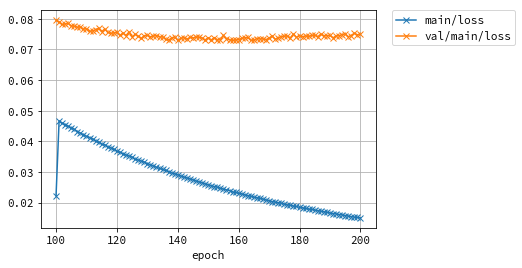

In [41]:
from IPython.display import Image
Image(filename="mnist_result/loss.png")

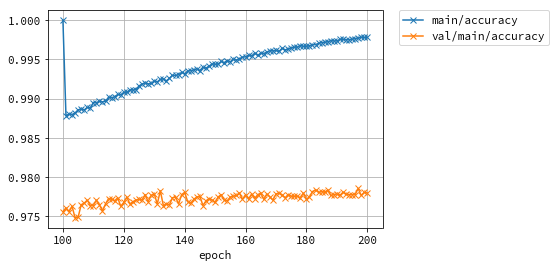

In [42]:
Image(filename="mnist_result/accuracy.png")

In [43]:
infer_net = MLP()

serializers.load_npz("mnist_result/snapshot_epoch-200", infer_net, path="updater/model:main/predictor/")

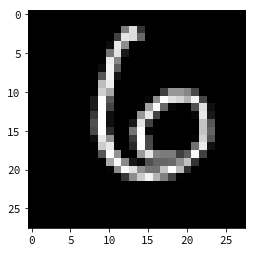

予測ラベル: 6


In [48]:
if gpu_id >= 0:
    infer_net.to_gpu(gpu_id)
    
x, t = test[100]
plt.imshow(x.reshape(28, 28), cmap="gray")
plt.show()

x = infer_net.xp.asarray(x[None, ...])
y = infer_net(x)
y = to_cpu(y.array)

print("予測ラベル:", y.argmax(axis=1)[0])